In [81]:
#!pip install textblob
#!pip install tweepy
#!pip install pycountry
#!pip install unidecode
#!pip install wordcloud
#!pip install langdetect
#!pip install transformers
#!pip install sentencepiece
#!pip install gradio
#!pip install pipeline
#!pip install pydot
#!pip install graphviz

In [1]:
#from textblob import TextBlob
#import sys
#import tweepy
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
#import os
import nltk
import re
#import pycountry
#import re
#import string
#import reprlib
#import sweetviz as sv
#import ast
#import datetime
#import rfc3339
#import iso8601      
#import os.path
import plotly.express as px
#import plotly.graph_objects as go
import unidecode
import nltk
from nltk.corpus import stopwords

#import snippets.python_snippets as psn
#import twitter_auth as tw_a1
#import twitter_authV2 as tw_a2
#import twitter_authV2UserContext as tw_a2v2uc

from wordcloud import WordCloud, STOPWORDS
#from PIL import Image
#from nltk.sentiment.vader import SentimentIntensityAnalyzer
from langdetect import detect
#from nltk.sentiment.vader import SentimentIntensityAnalyzer
from unidecode import unidecode
import xml.etree.ElementTree as et 
from sklearn.metrics import confusion_matrix
import pickle

######################################    CASO 0
from sklearn.preprocessing import LabelEncoder
import seaborn as sns
from sklearn.model_selection import train_test_split
#from sklearn.feature_extraction.text import CountVectorizer
#from sklearn.feature_extraction.text import TfidfVectorizer
from keras.preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences
import keras.backend as K

from keras.models import Sequential
from keras.layers import Embedding, Conv1D, MaxPooling1D, Bidirectional, LSTM, Dense, Dropout
from keras.metrics import Precision, Recall
from keras.optimizers import SGD
from keras.optimizers import RMSprop
from keras import datasets

from keras.callbacks import LearningRateScheduler
from keras.callbacks import History
import tensorflow as tf
from keras import losses
from keras.models import load_model
from nltk.util import ngrams


######################################    CASO 1
from sklearn.feature_extraction.text import CountVectorizer       
from nltk.stem import SnowballStemmer
from nltk.tokenize import word_tokenize
from string import punctuation

from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.svm import LinearSVC
from sklearn.pipeline import Pipeline
import joblib

######################################    CASO 2
from transformers import pipeline




%matplotlib inline

pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)

pd.set_option('display.max_rows', None)

stemmer = SnowballStemmer('spanish')
#pd.set_option('display.max_rowwidth', None)


# Funciones

In [2]:
####################################### FUNCION PARA LIMPIAR LOS TWEETS
def clean_text(tweets_df, column_name):
    #Conversion a minusculas
    tweets_df[column_name] = tweets_df[column_name].str.lower()
    
    #Eliminación de hashtags
    tweets_df[column_name] =  [re.sub(r'\\#[A-z]',' ', str(x)) for x in tweets_df[column_name]]
    #Eliminación de links
    tweets_df[column_name] =  [re.sub(r'\w+:\/{2}[\d\w-]+(\.[\d\w-]+)*(?:(?:\/[^\s/]*))*',' ', str(x)) for x in tweets_df[column_name]]
    #Eliminación de \n
    tweets_df[column_name] =  [re.sub(r'\n',' ', str(x)) for x in tweets_df[column_name]]
    #Eliminación de usuarios
    tweets_df[column_name] =  [re.sub(r'(?:\@|http?\://|https?\://|www)\S+',' ', str(x)) for x in tweets_df[column_name]]
    #Eliminación de puntuación
    tweets_df[column_name] =  [re.sub(r'[^\w\s]',' ', str(x)) for x in tweets_df[column_name]]
    #Eliminación de acentos
    tweets_df[column_name] = tweets_df[column_name].apply(lambda x:  unidecode(x))
    #Eliminación de numeros
    tweets_df[column_name] = [re.sub(r'[^a-zA-Z0-9]',' ', str(x)) for x in tweets_df[column_name]]
    tweets_df[column_name] = [re.sub(r'^[\d\s]+',' ', str(x)) for x in tweets_df[column_name]]
    #Eliminación de doble espacio
    tweets_df[column_name] =  [re.sub(r'/\s\s+/g',' ', str(x)) for x in tweets_df[column_name]]
    
    return tweets_df


####################################### FUNCION PARA LEER LOS XML
def df_from_xml(file_name):
    
    xtree = et.parse(file_name)
    xroot = xtree.getroot() 

    df_cols = ["tweetid", "content", "sentiments"]
    rows = []

    for node in xroot: 
        s_id = node.find("tweetid").text
        s_content = node.find("content").text if node is not None else None

        first = 1
        if(node.find("sentiment")):
            for sub_node in node.find("sentiment"):    
                sentiment = ""
                if(first == 1):
                    if(sub_node.find("value").text != None):
                        sentiment = sub_node.find("value").text

                first = 0
                s_sentiments = sentiment
        else:
            for sub_node in node.find("sentiments"):    
                if(first == 1):
                    if(sub_node.find("value").text != None):
                        sentiment = sub_node.find("value").text

                first = 0
                s_sentiments = sentiment

        rows.append({"tweetid": s_id, "content": s_content, 
                     "sentiments": s_sentiments})

    base_df = pd.DataFrame(rows, columns = df_cols)
    base_df = clean_text(base_df, 'content')

    return base_df

####################################### FUNCION PARA REALIZAR STEMMING DE LAS PALABRAS
def stem_tokens(tokens, stemmer):
    stemmed = []
    for item in tokens:
        stemmed.append(stemmer.stem(item))
    return stemmed

####################################### FUNCION PARA REALIZAR TOKENIZAR lAS PALABRAS
def tokenize(text):
    # remove non letters
    text = ''.join([c for c in text if c not in non_words])
    # tokenize
    tokens =  word_tokenize(text)

    # stem
    try:
        stems = stem_tokens(tokens, stemmer)
    except Exception as e:
        print(e)
        print(text)
        stems = ['']
    return stems

# Vista general

## En este cuaderno se estarán probando diversos métodos para el análisis de sentimientos, para determinar el método que se estaría implementando en el proyecto de tesis para el análisis de sentimientos de los tweets.

## Se estarán probando 4 casos diferentes: 
## Análisis de información
## 1. Redes LSTM
## 2. Linear SVC
## 3. Robertuito
## 4. TextBlob

## *+Consideraciones a tomar:*
   #### *-Se es consiente que el dataset utilizado es un dataset pequeño debido a que se obtuvo de la página que posee datasets con enfoque político: http://tass.sepln.org/ , y se quiso utilizar algo con mayor enfoque a lo que se estaría manejando* 
   #### *-La dimensión influye en los resultados, así como la región del español que se habla*
   #### *-Todavía hace falta métodos de preprocesamiento de la información para poder mejorar los resultados y en reunión con la maestra Olivia Gutu, se están viendo estos métodos.*
   #### *-No todos los métodos van a ser utilizados y en su mayoría solo se deben considerar como casos de prueba*
   #### *-Se están revisando factores y opciones para mejorar los resultados de algunos casos*
   #### *-El etiquetado de los tweets fue a criterio de la institución TASS y no siempre concuerdo con ellos.*

### Lectura de datos

#### En esta sección realizamos la  lectura de los documentos xml para extraer los tweets y sentimientos, asimismo eliminamos los registros vacíos y juntamos los DF

In [3]:
file_pol_name_train = "proy_data/politics-test-tagged.xml"
file_extra1_name_train = "proy_data/TASS2019_country_ES_train.xml"
file_extra2_name_train = "proy_data/general-train-tagged-3l.xml"
file_extra3_name_train = "proy_data/intertass-ES-development-tagged.xml"

file_name_train = "proy_data/TASS2019_country_MX_train.xml"
file_name_test = "proy_data/intertass-ES-train-tagged.xml"

train_pol_df = df_from_xml(file_pol_name_train)
train_extra1_df = df_from_xml(file_extra1_name_train)
train_extra2_df = df_from_xml(file_extra2_name_train)
train_extra3_df = df_from_xml(file_extra3_name_train)

train_df = df_from_xml(file_name_train)

train_df = train_df.append([train_pol_df,train_extra1_df,train_extra2_df,train_extra3_df], ignore_index=True)
train_df = train_df.drop(train_df[train_df.sentiments == 'NONE' ].index)

test_df = df_from_xml(file_name_test)
test_df = test_df.drop(test_df[test_df.sentiments == 'NONE' ].index)


/scratch/hrodriguez/111005/tmp.0MK0iqOQSi/ipykernel_361470/233861838.py:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_df = train_df.append([train_pol_df,train_extra1_df,train_extra2_df,train_extra3_df], ignore_index=True)


##### Justo como se menciona anteriormente, se puede observar un DF bajo en ejemplos y con un desbalance en la categoría neutral

In [4]:
#train_extra1_df.head(3)
dist = train_df['sentiments'].value_counts().reset_index()
print(dist)

  index  sentiments
0     P        4345
1     N        4078
2   NEU        1899


In [5]:
train_df['sentiments'].isnull().sum()

0

In [6]:
train_df.sample(20)

,tweetid,content,sentiments
8635,168301007388946432,vamos a formar a proteger los derechos de las personas de mas de 80 anos que son un 5 de la poblacion en espana,P
1857,137244767338766336,ahora estan tan enfrentados q no son operativos solo chacon puede dar un golpe d estado,N
7873,164096942220124161,camps x primera vez en un plato tras ser declarado inocente campsgatoalagua,P
1742,137242978090614784,el voto a iu es un voto de dignidad y de rebeldia rebelate,P
442,815916434060701697,escuchan now you re gone de uno de los mejores discos del 2016 propuestamananera,P
11056,184047379232731136,momento de reflexion para rajoy politica no es la cajera de un supermercado que suma productos por codigo de ba,N
5889,150343863435919360,el cni pasa a vicepresidencia por la evolucion de los servicios de inteligencia,P
10356,179551079808249857,y por otro lado el psoe no cree q el 5 8 sea un objetivo realista pero no dice cual lo seria ni como llegar a el,N
4902,144565001825423361,rt en los periodicos falta calor sudor humanidad gran entrevista sobre periodismo via,NEU
6697,156826201896398848,manana en mi dos palabras cuando la corrupcion se convierte en nuestro peor enemigo,N


## Depuración

In [10]:
#nltk.download("stopwords")
esp_stopwords = stopwords.words('spanish')
esp_stopwords.extend(['q', 'ma', 'rt', 'd', '20n', 'rajoy','va', 'de', 'en', 'de', 'la',])# '0','1','2','3','4','5','6','7','8','9'
#print((esp_stopwords))

non_words = list(punctuation)
non_words.extend(['¿', '¡'])
non_words.extend(map(str,range(10)))

### Distribución

In [5]:
dist = train_df['sentiments'].value_counts().reset_index()
print(dist)

  index  sentiments
0     P        4345
1     N        4078
2   NEU        1899


In [6]:
dist = test_df['sentiments'].value_counts().reset_index()
print(dist)

  index  sentiments
0     N         418
1     P         318
2   NEU         133


## Wordcloud positivos

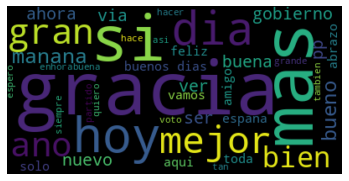

In [10]:
positive_df = train_df[train_df.sentiments == 'P' ]
#Revisar nube de palabras con bigramas <- No funciona: los ngramas que regresan, no dicen nada. preguntar a maestra
pos_string = " ".join(tw for tw in positive_df.content)


#funcion para obtener ngramas
"""
def get_ngrams(text, n=2):
    text = str(text)
    n_grams = ngrams(text.split(), n)
    returnVal = []
    
    try:
        for grams in n_grams:
            returnVal.append('_'.join(grams))
    except(RuntimeError):
        pass
        
    return ' '.join(returnVal).strip()
pos_string = " ".join(get_ngrams(tw) for tw in positive_df.content)
"""
positive_wordcloud2 = WordCloud(stopwords=esp_stopwords, max_words=40).generate(pos_string)
plt.imshow(positive_wordcloud2, interpolation='bilinear')
plt.axis("off")
plt.show()

## Wordcloud negativo

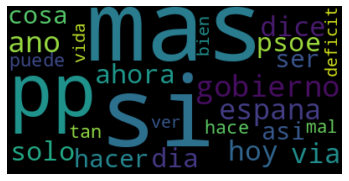

In [11]:
negative_df = train_df[train_df.sentiments == 'N' ]
neg_string = " ".join(tw for tw in negative_df.content)

neg_wordcloud2 = WordCloud(stopwords=esp_stopwords, max_words=25).generate(neg_string)
plt.imshow(neg_wordcloud2, interpolation='bilinear')
plt.axis("off")
plt.show()

## Wordcloud neutros

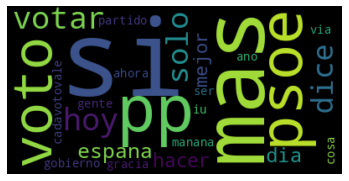

In [12]:
neutral_df = train_df[train_df.sentiments == 'NEU' ]
neu_string = " ".join(tw for tw in neutral_df.content)

neu_wordcloud2 = WordCloud(stopwords=esp_stopwords, max_words=25).generate(neu_string)
plt.imshow(neu_wordcloud2, interpolation='bilinear')
plt.axis("off")
plt.show()

# CASO 0 - LSTM

#### Este caso vamos a estar creando una red LSTM, tomando en cuenta que todavía se requieren diversos ajustes, así como un corpus más robusto, de enfoque político en español y de mayor cantidad para poder obtener mejores resultados. <br><br> *<b>Nota:<b> este no es el modelo seleccionado para implementar en la plataforma, hasta que se optimice y en su caso pueda arrojar mejores resultados que robertuito

In [19]:
#Generamos los df para este ejemplo
c0_tweets_corpus_train = train_df.copy()
c0_tweets_corpus_test = test_df.copy()
#stopword_re = re.compile("|".join(r"\b%s\b" % re.escape(word) for word in esp_stopwords))

#c0_tweets_corpus['sentiments'] = c0_tweets_corpus['sentiments'].map({'N': -1.0, 'NEU': 0.0, 'P':1.0})
#c0_tweets_corpus_train.sample(20)

<AxesSubplot:>

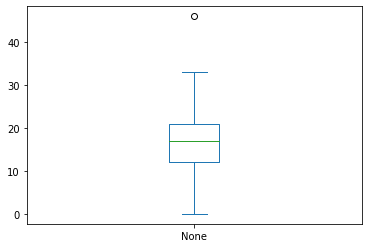

In [14]:
#Aqui vamos a ver la distribución de la longitud del los tweets totales, y como se puede observar tenemos un caso rebelde de outlier

#Obtenemos la longuitud de los tweets
tweet_len = pd.Series([len(tweet.split()) for tweet in c0_tweets_corpus_train['content']])

#Graficamos la distibucion de la longitud
tweet_len.plot(kind='box')

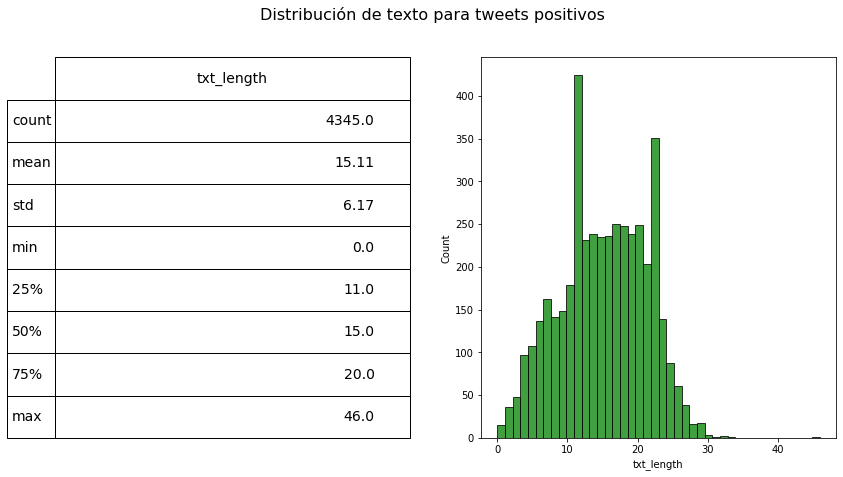

In [15]:
# Aqui Se va a observar la distribución de la longitud de los tweets catalogados como positivos
fig = plt.figure(figsize=(14,7))
c0_tweets_corpus_train['txt_length'] = c0_tweets_corpus_train['content'].str.split().apply(len)
ax1 = fig.add_subplot(122)
sns.histplot(c0_tweets_corpus_train[c0_tweets_corpus_train['sentiments']=='P']['txt_length'], ax=ax1,color='green')
describe = c0_tweets_corpus_train[c0_tweets_corpus_train['sentiments']=='P']['txt_length'].describe().to_frame().round(2)

ax2 = fig.add_subplot(121)
ax2.axis('off')
font_size = 14
bbox = [0, 0, 1, 1]
table = ax2.table(cellText = describe.values, rowLabels = describe.index, bbox=bbox, colLabels=describe.columns)
table.set_fontsize(font_size)
fig.suptitle('Distribución de texto para tweets positivos', fontsize=16)

plt.show()

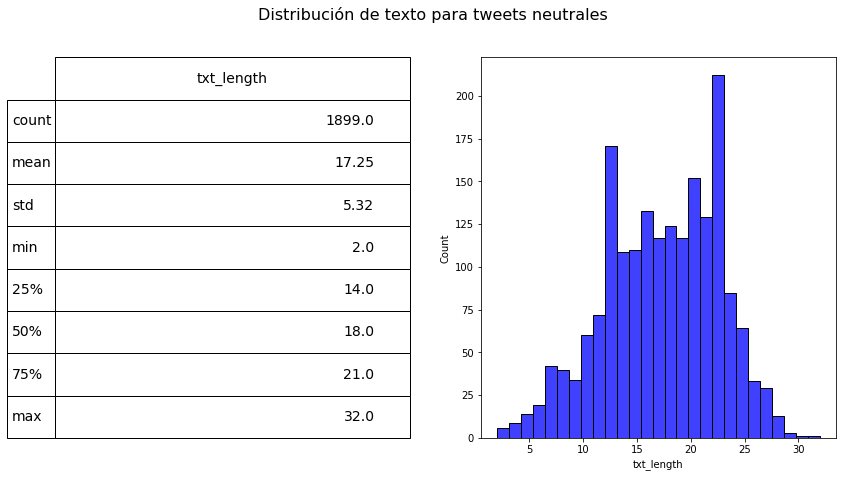

In [45]:
# Aqui Se va a observar la distribución de la longitud de los tweets catalogados como neutrales
fig = plt.figure(figsize=(14,7))
c0_tweets_corpus_train['txt_length'] = c0_tweets_corpus_train['content'].str.split().apply(len)
ax1 = fig.add_subplot(122)
sns.histplot(c0_tweets_corpus_train[c0_tweets_corpus_train['sentiments']=='NEU']['txt_length'], ax=ax1,color='blue')
describe = c0_tweets_corpus_train[c0_tweets_corpus_train['sentiments']=='NEU']['txt_length'].describe().to_frame().round(2)

ax2 = fig.add_subplot(121)
ax2.axis('off')
font_size = 14
bbox = [0, 0, 1, 1]
table = ax2.table(cellText = describe.values, rowLabels = describe.index, bbox=bbox, colLabels=describe.columns)
table.set_fontsize(font_size)
fig.suptitle('Distribución de texto para tweets neutrales', fontsize=16)

plt.show()

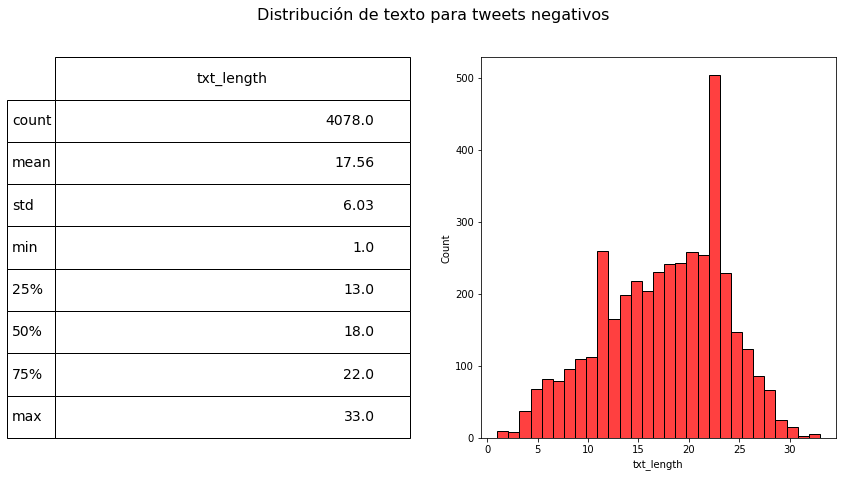

In [17]:
# Aqui Se va a observar la distribución de la longitud de los tweets catalogados como negativos

fig = plt.figure(figsize=(14,7))
c0_tweets_corpus_train['txt_length'] = c0_tweets_corpus_train['content'].str.split().apply(len)
ax1 = fig.add_subplot(122)
sns.histplot(c0_tweets_corpus_train[c0_tweets_corpus_train['sentiments']=='N']['txt_length'], ax=ax1,color='red')
describe = c0_tweets_corpus_train[c0_tweets_corpus_train['sentiments']=='N']['txt_length'].describe().to_frame().round(2)

ax2 = fig.add_subplot(121)
ax2.axis('off')
font_size = 14
bbox = [0, 0, 1, 1]
table = ax2.table(cellText = describe.values, rowLabels = describe.index, bbox=bbox, colLabels=describe.columns)
table.set_fontsize(font_size)
fig.suptitle('Distribución de texto para tweets negativos', fontsize=16)

plt.show()

## *OBSERVACIÓN: En la sección anterior de gráficos se pueden observar un fenómeno curioso pero lógico. En la distribución positiva, los tweets están compuestos de un menor número de palabras, en al neutral se encuentra bastante orientado al centro y en los tweets negativos la distribución se inclina a la derecha, mostrando así que este tipo de tweets tienden a tener más palabras, lo que determina que alguien enojado.. Tiene más que decir.

In [18]:
max_words = 500000
max_len=50 #Maximo de palabras por tweet

#c0_tweets_corpus_train["content"].replace(stopword_re, "", inplace=True)


#Convertiremos cada texto en secuencias numericas conforme a su token y rellenaremos con 0's 
#los espacios vacios para homologar ls dimensiones
def tokenize_tw(text):
    #tokenización
    tokenizer = Tokenizer(num_words=max_words, lower=True, split=' ')
    tokenizer.fit_on_texts(text)
    
    #Texto a enteros
    X = tokenizer.texts_to_sequences(text)
    
    #Rellenamos
    X = pad_sequences(X, padding='post', maxlen=max_len)

    return X, tokenizer

#Calculo de f1
def f1_score(precision, recall):
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

print('Tweet original: \n', c0_tweets_corpus_train['content'][0])
X_base, tokenizer = tokenize_tw(c0_tweets_corpus_train['content'])
X_test, tokenizer_test = tokenize_tw(c0_tweets_corpus_test['content'])

print('\nTweet modificado: \n', X_base[0])


Tweet original: 
  nivel de ingles    alto    traduzca juguete    toy    uselo en una oracion    toy triste    a  vengache pa  aca   

Tweet modificado: 
 [ 912    1 2176 1182 8785 4280 4281 8786    7   20 5746 4281  255    3
 8787  438 1456    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0]


In [19]:
#Guardamos el pepinillo
with open('proy_extras/tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

#Sacamos el pepinillo
with open('proy_extras/tokenizer.pickle', 'rb') as handle:
    tokenizer = pickle.load(handle)

In [16]:
#Rellenamos las categorias con 0's
y_base = pd.get_dummies(c0_tweets_corpus_train['sentiments'])
y_test = pd.get_dummies(c0_tweets_corpus_test['sentiments'])

X_train, X_val, y_train, y_val = train_test_split(X_base, y_base, test_size=0.2, random_state=1)


print('Train ->', X_train.shape, y_train.shape)
print('Val ->', X_val.shape, y_val.shape)
print('Test ->', X_test.shape, y_test.shape)

Train -> (8257, 50) (8257, 3)
Val -> (2065, 50) (2065, 3)
Test -> (869, 50) (869, 3)


## Segmento de prueba

In [57]:
from keras.wrappers.scikit_learn import KerasClassifier
import time
import keras_tuner as kt


vocab_size = 50000
embedding_size = 32
#epochs=80
#learning_rate_ = 0.1
#decay_rate = learning_rate_ / epochs
#momentum = 0.5

#sgd = SGD(learning_rate=learning_rate_, momentum=momentum, decay=decay_rate, nesterov=False)#Stocastic Gradient descend

#Construcción del modelo
def create_model2(hp):
    model= Sequential()
    model.add(Embedding(vocab_size, embedding_size, input_length=max_len))
    
    model.add(Conv1D(filters=hp.Int('units_1', min_value=16, max_value=256, step=5), kernel_size=3, padding='same', activation='relu'))
    
    model.add(MaxPooling1D(pool_size=2))
    model.add(Bidirectional(LSTM(hp.Int('units_2', min_value=16, max_value=256, step=5))))
    
    drop_rate = hp.Choice('droprate', values=[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8])
    model.add(Dropout(drop_rate))
    
    model.add(Dense(3, activation='softmax'))
    
    #callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

    hp_learning_rate = hp.Choice('learning_rate', values=[0.1, 1e-2, 1e-3, 1e-4])
    hp_momentum = hp.Choice('learning_rate', values=[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8])

    sgd = create_optimizer(hp_learning_rate, hp_momentum)

    model.compile(loss='mse', optimizer=sgd, metrics=['accuracy'])
    
    return model


tuner = kt.Hyperband( # https://keras.io/api/keras_tuner/tuners/hyperband/ 
    create_model2,   
    objective='accuracy',
    max_epochs=80,
    factor=8,
    directory='salida_testing',
    project_name='HP_tuning',
    overwrite=True 
)

tuner.search_space_summary()

stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5)
t = time.time()
%time tuner.search(X_train, y_train, validation_data=(X_val, y_val),  verbose =1)#callbacks=[stop_early],
print(f'Tiempo de búsqueda {time.time() - t:.5f} sec')
best_hps = tuner.get_best_hyperparameters()[0]
best_hps.values
"""
def create_model(units, dropout, learning_rate_, momentum):
    model= Sequential()
    model.add(Embedding(vocab_size, embedding_size, input_length=max_len))
    model.add(Conv1D(filters=units, kernel_size=3, padding='same', activation='relu'))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Bidirectional(LSTM(units)))
    model.add(Dropout(dropout))
    model.add(Dense(3, activation='softmax'))
    
    callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

    sgd = create_optimizer(learning_rate_, momentum)

    model.compile(loss='mse', optimizer=sgd, metrics=['accuracy'])
    
    return model

def create_optimizer(learning_rate_, momentum):
    decay_rate = learning_rate_ / 70
    sgd = SGD(learning_rate=learning_rate_, momentum=momentum, decay=decay_rate, nesterov=False)#Stocastic Gradient descend

    return sgd


epochs = [50,80]
batch_size = [32, 64]
units = [8,16,32,64,128]
dropout = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8]
learning_rate_ = [0.1, 0.05, 0.5, 0.01, 0.005, 0.001]
momentum = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8]


param_grid        = dict(units=units, dropout=dropout, learning_rate_=learning_rate_, momentum=momentum, epochs=epochs, batch_size=batch_size)

model = KerasClassifier(build_fn = create_model, verbose = 1)

grid = GridSearchCV(
                    estimator          = model, 
                    param_grid         = param_grid, 
                    n_jobs             = 1, 
                    cv                 = 5, 
                    return_train_score = True
)

t = time.time()

%time grid_result = grid.fit(X_train, y_train, validation_data=(X_val, y_val), verbose=1)

print(f'Tiempo de entrenamiento {(time.time() - t)/60} mins')

print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
"""


Trial 121 Complete [00h 01m 57s]
accuracy: 0.43151265382766724

Best accuracy So Far: 0.5199224948883057
Total elapsed time: 00h 30m 48s
INFO:tensorflow:Oracle triggered exit
CPU times: user 39min 36s, sys: 3min 9s, total: 42min 46s
Wall time: 30min 47s
Tiempo de búsqueda 1847.85215 sec


'\ndef create_model(units, dropout, learning_rate_, momentum):\n    model= Sequential()\n    model.add(Embedding(vocab_size, embedding_size, input_length=max_len))\n    model.add(Conv1D(filters=units, kernel_size=3, padding=\'same\', activation=\'relu\'))\n    model.add(MaxPooling1D(pool_size=2))\n    model.add(Bidirectional(LSTM(units)))\n    model.add(Dropout(dropout))\n    model.add(Dense(3, activation=\'softmax\'))\n    \n    callback = tf.keras.callbacks.EarlyStopping(monitor=\'val_loss\', patience=5)\n\n    sgd = create_optimizer(learning_rate_, momentum)\n\n    model.compile(loss=\'mse\', optimizer=sgd, metrics=[\'accuracy\'])\n    \n    return model\n\ndef create_optimizer(learning_rate_, momentum):\n    decay_rate = learning_rate_ / 70\n    sgd = SGD(learning_rate=learning_rate_, momentum=momentum, decay=decay_rate, nesterov=False)#Stocastic Gradient descend\n\n    return sgd\n\n\nepochs = [50,80]\nbatch_size = [32, 64]\nunits = [8,16,32,64,128]\ndropout = [0.1, 0.2, 0.3, 0.4,

## Retomando

In [28]:
#Parametros
vocab_size = 5000
embedding_size = 32
epochs=80
learning_rate_ = 0.1
decay_rate = learning_rate_ / epochs
momentum = 0.5

#Construcción del optimizador, tal vez adam?
sgd = SGD(learning_rate=learning_rate_, momentum=momentum, decay=decay_rate, nesterov=False)#Stocastic Gradient descend

#Construcción del modelo
model= Sequential()
model.add(Embedding(vocab_size, embedding_size, input_length=max_len))
model.add(Conv1D(filters=256, kernel_size=3, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))
#model.add(Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'))
#model.add(MaxPooling1D(pool_size=2))
model.add(Bidirectional(LSTM(125)))
#model.add(Dropout(0.1))
model.add(Dense(3, activation='softmax'))

In [29]:
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 50, 32)            160000    
                                                                 
 conv1d_1 (Conv1D)           (None, 50, 256)           24832     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 25, 256)          0         
 1D)                                                             
                                                                 
 bidirectional_1 (Bidirectio  (None, 250)              382000    
 nal)                                                            
                                                                 
 dense_1 (Dense)             (None, 3)                 753       
                                                                 
Total params: 567,585
Trainable params: 567,585
Non-tr

In [30]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
model.compile(loss='mse', optimizer=sgd, metrics=['accuracy'])

In [31]:
batch_size = 32
history = model.fit(X_train, y_train, validation_data=(X_val, y_val),
                      batch_size=batch_size, epochs=epochs, callbacks=[callback], verbose=1)

Epoch 1/80
259/259 [==============================] - 4s 7ms/step - loss: 0.2115 - accuracy: 0.4175 - val_loss: 0.2108 - val_accuracy: 0.4087
Epoch 2/80
259/259 [==============================] - 1s 5ms/step - loss: 0.2106 - accuracy: 0.4270 - val_loss: 0.2105 - val_accuracy: 0.4533
Epoch 3/80
259/259 [==============================] - 1s 5ms/step - loss: 0.2100 - accuracy: 0.4385 - val_loss: 0.2100 - val_accuracy: 0.4475
Epoch 4/80
259/259 [==============================] - 1s 5ms/step - loss: 0.2091 - accuracy: 0.4544 - val_loss: 0.2091 - val_accuracy: 0.4538
Epoch 5/80
259/259 [==============================] - 1s 5ms/step - loss: 0.2077 - accuracy: 0.4750 - val_loss: 0.2078 - val_accuracy: 0.4625
Epoch 6/80
259/259 [==============================] - 1s 5ms/step - loss: 0.2065 - accuracy: 0.4772 - val_loss: 0.2073 - val_accuracy: 0.4596
Epoch 7/80
259/259 [==============================] - 1s 5ms/step - loss: 0.2058 - accuracy: 0.4778 - val_loss: 0.2072 - val_accuracy: 0.4625
Epoch 

In [32]:
#Evaluamos que tan jodido esta el asunto
loss, accuracy = model.evaluate(X_val, y_val, verbose=1)

print('')
print('Accuracy  : {:.4f}'.format(accuracy))
print('Loss : {:.4f}'.format(loss))

65/65 [==============================] - 0s 2ms/step - loss: 0.1940 - accuracy: 0.5482

Accuracy  : 0.5482
Loss : 0.1940


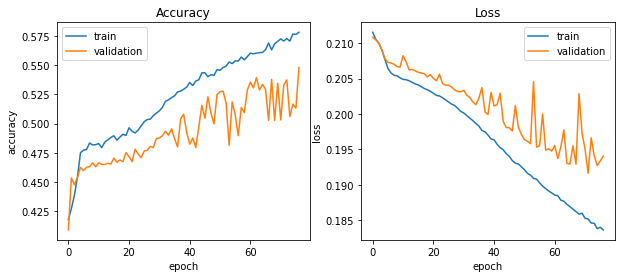

In [33]:
def plot_training_hist(history):    
    fig, ax = plt.subplots(1, 2, figsize=(10,4))

    ax[0].plot(history.history['accuracy'])
    ax[0].plot(history.history['val_accuracy'])
    ax[0].set_title('Accuracy')
    ax[0].set_xlabel('epoch')
    ax[0].set_ylabel('accuracy')
    ax[0].legend(['train', 'validation'], loc='best')

    ax[1].plot(history.history['loss'])
    ax[1].plot(history.history['val_loss'])
    ax[1].set_title('Loss')
    ax[1].set_xlabel('epoch')
    ax[1].set_ylabel('loss')
    ax[1].legend(['train', 'validation'], loc='best')
    
    
plot_training_hist(history)

28/28 [==============================] - 1s 2ms/step


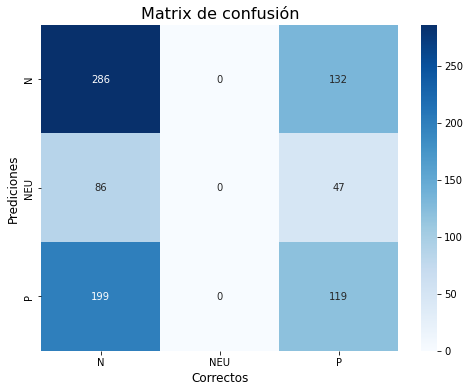

In [34]:
def plot_confusion_matrix(model, X_test, y_test):    
    sentiment_classes = ['N', 'NEU', 'P']
    y_pred = model.predict(X_test)
    cm = confusion_matrix(np.argmax(np.array(y_test),axis=1), np.argmax(y_pred, axis=1))

    plt.figure(figsize=(8,6))
    sns.heatmap(cm, cmap=plt.cm.Blues, annot=True, fmt='d', 
                xticklabels=sentiment_classes,
                yticklabels=sentiment_classes)
    plt.title('Matrix de confusión', fontsize=16)
    plt.xlabel('Correctos', fontsize=12)
    plt.ylabel('Prediciones', fontsize=12)
    
plot_confusion_matrix(model, X_test, y_test)

In [35]:
# Guardamos el modelo para futuras referencias
model.save('model_tofix_mmmm.h5')
print('Model saved')

Model saved


In [36]:
model = load_model('model_tofix_mmmm.h5')

#funcion para predecir
def predict_tw(text):    
    sentiment_classes = ['N', 'NEU', 'P']
    max_len=50
    xt = tokenizer.texts_to_sequences(text)

    xt = pad_sequences(xt, padding='post', maxlen=max_len)

    yt = model.predict(xt).argmax(axis=1)

    print('La predicción es: ', sentiment_classes[yt[0]])

In [37]:
predict_tw(['que buen día'])

1/1 [==============================] - 0s 476ms/step
La predicción es:  P


In [38]:
predict_tw(['me da igual la vida'])

1/1 [==============================] - 0s 14ms/step
La predicción es:  N


In [43]:
predict_tw(['me caga el sol'])

1/1 [==============================] - 0s 14ms/step
La predicción es:  N


In [44]:
predict_tw(['Texto sin motivo'])

1/1 [==============================] - 0s 14ms/step
La predicción es:  N


### Conclusión: los parámetros faltan de ajustarse a su forma óptima, la red muestra que estaba mejorando poco a poco, sin embargo, es un factor determinante el tener un dataset más grande y balanceado, reitero este dataset se agarró como prueba sin intención de usarse para entrenar el modelo final.

# END TEST 1

# CASO 1 - LINEAR SVC

### Este caso manejan los SVC lineares, sin embargo, presenta la misma situación que el model anterior al tener un dataset limitado. Asimismo, la publicación original carece de muchas justificaciones para el uso de ciertas técnicas, por lo cual este caso se debe tomar como un caso de experimentación más para aprender y de curiosidad, que cualquier otro motivo.

### Polaridad general

In [25]:
c1_tweets_corpus = train_df[train_df.sentiments != 'NEU']
c1_tweets_corpus['polarity_bin'] = 0
c1_tweets_corpus.polarity_bin[c1_tweets_corpus.sentiments.isin(['P', 'P+'])] = 1
c1_tweets_corpus.polarity_bin.value_counts(normalize=True)

/scratch/hrodriguez/110707/tmp.co81fkXUWF/ipykernel_159561/2229378815.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  c1_tweets_corpus['polarity_bin'] = 0
/scratch/hrodriguez/110707/tmp.co81fkXUWF/ipykernel_159561/2229378815.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  c1_tweets_corpus.polarity_bin[c1_tweets_corpus.sentiments.isin(['P', 'P+'])] = 1


0    0.552749
1    0.447251
Name: polarity_bin, dtype: float64

In [26]:
c1_tweets_corpus.head(5)

,tweetid,content,sentiments,polarity_bin
1,772486813948575745,si soy de area y con suerte pase mate iv y mate v por que me ponen al profe qlero que es mega dificil pasar con el en mi ultimo ano,N,0
2,771871884451295233,sabian que su after fav teatro g fue construido para mi y un dia de estos hoy les voy a dar el placer de que me vean ahi metido,P,1
3,771947976302456832,y hoy por primera vez me sali con el permiso de mi mujer pero no es eso el detalle si no saber q estaran a mi lado y q llegare a casa,P,1
4,774741645484896256,para que hacen coraje con ambriz al final no lo van a correr y saldra con su tipica frase la culpa es mia no de los jugadores,N,0
5,773634625126043649,yo mama por que nunca en dejaste disfrutar mi juventud ya tengo mama felipe llegabas borracho a los anos yo ayn mama,N,0


In [27]:
# Convierte el texto en una matriz de tokens
vectorizer = CountVectorizer(
                analyzer = 'word',
                tokenizer = tokenize,
                lowercase = True,
                stop_words = esp_stopwords)

#creación del pipeline
pipeline = Pipeline([
    ('vect', vectorizer),
    ('cls', LinearSVC()),#Linear Support Vector Classification
])

#Establecer rangos de parametros para busqueda
parameters = {
    'vect__max_df': (0.1, 1.0),
    'vect__min_df': (10, 20,50),
    'vect__max_features': (500, 1000),
    'vect__ngram_range': ((1,1),(1, 2)),  # unigrams or bigrams
    'cls__C': (0.2, 0.5, 0.7),
    'cls__loss': ('hinge', 'squared_hinge'),
    'cls__max_iter': (500, 1000)
}

#Entrenamos
grid_search_model = GridSearchCV(pipeline, parameters, n_jobs=-1 , scoring='roc_auc', verbose = True)
grid_search_model.fit(c1_tweets_corpus.content, c1_tweets_corpus.polarity_bin)

Fitting 5 folds for each of 288 candidates, totalling 1440 fits


/LUSTRE/home/hrodriguez/.local/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:394: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['algun', 'com', 'contr', 'cuand', 'desd', 'dond', 'durant', 'eram', 'estab', 'estais', 'estam', 'estan', 'estand', 'estaran', 'estaras', 'esteis', 'estem', 'esten', 'estes', 'estuv', 'fuer', 'fues', 'fuim', 'fuist', 'hab', 'habr', 'habran', 'habras', 'hast', 'hem', 'hub', 'mas', 'mia', 'mias', 'mio', 'mios', 'much', 'nad', 'nosotr', 'nuestr', 'par', 'per', 'poc', 'porqu', 'qui', 'seais', 'seam', 'sent', 'ser', 'seran', 'seras', 'si', 'sient', 'sint', 'sobr', 'som', 'suy', 'tambien', 'tant', 'ten', 'tendr', 'tendran', 'tendras', 'teng', 'tien', 'tod', 'tuv', 'tuy', 'vosotr', 'vuestr'] not in stop_words.
  warnings.warn(
/LUSTRE/home/hrodriguez/.local/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:394: UserWarning: Your stop_words may be inconsistent with you

GridSearchCV(estimator=Pipeline(steps=[('vect',
                                        CountVectorizer(stop_words=['de', 'la',
                                                                    'que', 'el',
                                                                    'en', 'y',
                                                                    'a', 'los',
                                                                    'del', 'se',
                                                                    'las',
                                                                    'por', 'un',
                                                                    'para',
                                                                    'con', 'no',
                                                                    'una', 'su',
                                                                    'al', 'lo',
                                                                    'como',
                                                                    'más',
                                                                    'pero',
                                                                    'sus', 'le',
                                                                    'ya', 'o',
                                                                    'este',
                                                                    'sí',
                                                                    'porque', ...],
                                                        tokenizer=<function tokenize at 0x7ff6ebc91a60>)),
                                       ('cls', LinearSVC())]),
             n_jobs=-1,
             param_grid={'cls__C': (0.2, 0.5, 0.7),
                         'cls__loss': ('hinge', 'squared_hinge'),
                         'cls__max_iter': (500, 1000),
                         'vect__max_df': (0.1, 1.0),
                         'vect__max_features': (500, 1000),
                         'vect__min_df': (10, 20, 50),
                         'vect__ngram_range': ((1, 1), (1, 2))},
             scoring='roc_auc', verbose=True)

In [28]:
#Muestra mejores parametros
grid_search_model.best_params_

{'cls__C': 0.2,
 'cls__loss': 'hinge',
 'cls__max_iter': 500,
 'vect__max_df': 1.0,
 'vect__max_features': 1000,
 'vect__min_df': 10,
 'vect__ngram_range': (1, 2)}

In [29]:
#salvamos el modelo base
joblib.dump(grid_search_model, 'grid_search_model_Base.pkl')

['grid_search_model_Base.pkl']

In [30]:
#se realiza cross validation para determinar el performance
model = LinearSVC(C=.2, loss='squared_hinge',max_iter=1000,multi_class='ovr',
              random_state=None,
              penalty='l2',
              tol=0.0001
)

vectorizer = CountVectorizer(
    analyzer = 'word',
    tokenizer = tokenize,
    lowercase = True,
    stop_words = esp_stopwords,
    min_df = 50,
    max_df = 1.0,
    ngram_range=((1,2)),
    max_features=1000
)

corpus_data_features = vectorizer.fit_transform(c1_tweets_corpus.content)
corpus_data_features_nd = corpus_data_features.toarray()

scores = cross_val_score(
    model,
    corpus_data_features_nd[0:len(c1_tweets_corpus)],
    y=c1_tweets_corpus.polarity_bin,
    scoring='roc_auc',
    cv=5
    )

scores.mean()

/LUSTRE/home/hrodriguez/.local/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:394: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['algun', 'com', 'contr', 'cuand', 'desd', 'dond', 'durant', 'eram', 'estab', 'estais', 'estam', 'estan', 'estand', 'estaran', 'estaras', 'esteis', 'estem', 'esten', 'estes', 'estuv', 'fuer', 'fues', 'fuim', 'fuist', 'hab', 'habr', 'habran', 'habras', 'hast', 'hem', 'hub', 'mas', 'mia', 'mias', 'mio', 'mios', 'much', 'nad', 'nosotr', 'nuestr', 'par', 'per', 'poc', 'porqu', 'qui', 'seais', 'seam', 'sent', 'ser', 'seran', 'seras', 'si', 'sient', 'sint', 'sobr', 'som', 'suy', 'tambien', 'tant', 'ten', 'tendr', 'tendran', 'tendras', 'teng', 'tien', 'tod', 'tuv', 'tuy', 'vosotr', 'vuestr'] not in stop_words.
  warnings.warn(


0.6142027542880698

In [45]:
local_test_df = test_df.copy()
local_test_df = local_test_df.drop(local_test_df[local_test_df.sentiments == 'NEU' ].index)
pipeline.fit(c1_tweets_corpus.content, c1_tweets_corpus.polarity_bin)
local_test_df['predictions'] = pipeline.predict(local_test_df.content)
local_test_df['sentiments'] = local_test_df['sentiments'].replace(['P'], 1)
local_test_df['sentiments'] = local_test_df['sentiments'].replace(['N'], 0)
#local_test_df['sentiments'].replace({'P': 1})
#local_test_df['sentiments'].replace({'N': 0})
local_test_df[['content', 'predictions', 'sentiments']].sample(20)

,content,predictions,sentiments
567,felicidades pareja peazo abuelo va a tener tu hijo estara pletorico,0,1
455,estoy en una montana rusa emocional en la que pilotan mis ovarios de putis,0,0
625,hoy directillo de fifa senores un poquito de liverpool que queda menos para terminar,1,1
984,no me habeis curado el sad,0,0
496,se que no me vas a leer pero si pudieras decirme a que hora coges el ave a manana me harias muy feliz no he podido verte hoy,1,0
196,ohhhhh eso tiene que ser muy divertido me imagino que los hombres estan vetados no,0,1
214,work from home seria espectacular y poder verlas mas conmtval727tour,0,1
871,siento el spam quiero que comprendais y compartais conmigo la felicidad de este momento espero ser el mejor capitan de todos,0,1
833,si esta claro la culpa es mia,0,0
820,gracias por la info lo bueno seria saber si aceptan libros en ingles,1,1


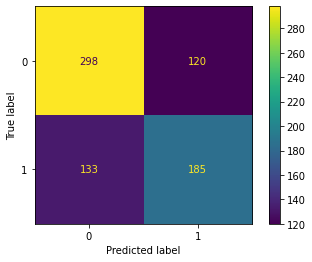

In [100]:
y_eval = local_test_df[["sentiments"]].to_numpy()
pred_eval = local_test_df[["predictions"]].to_numpy()


con = confusion_matrix(y_eval, pred_eval)
from sklearn.metrics import  ConfusionMatrixDisplay
disp = ConfusionMatrixDisplay( confusion_matrix=con ) 
disp.plot()
plt.show()

### Conclusion: Este modelo no responde de manera tan negativa sin embargo al faltar mucha documentación sobre el tema y ser solo para clasificar entre negativo y positivo, limita mucho la intención del proyecto, por lo cual no se considera para modelo final.

# CASO 2 - ROBERTUITO

In [127]:
from transformers import pipeline
sentiment_pipeline = pipeline('text-classification', 
                              model="pysentimiento/robertuito-sentiment-analysis")


In [158]:
#texto_prueba = "Feliz matanza en la escuela vaquero"
#texto_prueba = "Hasta crees que lo vas a lograr"
#texto_prueba = "No eres tu, soy yo"
#texto_prueba = "El clima de hoy es calido"
#texto_prueba = "te voy a reprobar"
texto_prueba = "que valiente yo no me atreveria"
#texto_prueba = "que desperdicio porque eres gay"


sentiment_pipeline(texto_prueba)

[{'label': 'NEU', 'score': 0.7619125843048096}]

In [192]:
test_df.tail(10)

,tweetid,content,sentiments
996,800879934830997504,con lo tranquila que yo estaba,NEU
997,802284370715361280,un nosotros asi de grande por hoy,P
998,801548408452423681,se fue a rusia tio,N
999,801914961752625152,tanto sad tanto sad pues yo tambien estoy muy sad hoy,N
1002,810494304795983872,estan todos muy sad hoy no,N
1003,814846333601320960,para mi mi mejor ano fue el,P
1004,813731371076243461,hoy va a ser un dia muy largo,N
1005,818399956792905728,que no me encuentre mal,NEU
1006,815715581878009858,es que son muy bonitas jo,P
1007,816978031357161476,que no jo que no soy tan irresponsable,P


In [201]:
def split_sentiment_polarity(df, column):
    tweet_info_ls = []
    
    for elem in df[column]:

        tweet_info = {
                    'predictions': elem[0]['label'],
                    'score': elem[0]['score'],
                }
        
        tweet_info_ls.append(tweet_info)
        
    tweets_df = pd.DataFrame(tweet_info_ls)
    
    df = df.reset_index()
    df['predictions'] = tweets_df['predictions'].values
    df['score'] = tweets_df['score'].values
    
    return df
    


In [205]:
test_case2 = test_df.copy()
test_case2['polarity'] = test_case2.content.apply(lambda x : sentiment_pipeline(x))

In [209]:
test_case2 = split_sentiment_polarity(test_case2, 'polarity')

In [210]:
test_case2.sample(10)

,index,tweetid,content,sentiments,polarity,predictions,score
642,738,770988960906616832,se ha ido de mi espalda y no se como ha acabado dejandome en una esquinita de mi propia cama,N,"[{'label': 'NEG', 'score': 0.9954349398612976}]",NEG,0.995435
600,690,771043016106708992,estos dias me encuentro muy debil espero que se me pase pronto,N,"[{'label': 'NEG', 'score': 0.9970337152481079}]",NEG,0.997034
672,778,770547133846024192,no sabia que la remasterizada se parecia a la primera temporada de falcon crest,NEU,"[{'label': 'NEU', 'score': 0.858910858631134}]",NEU,0.858911
59,70,768562234582851584,por desgracia el sorteo que tenia pensado hacer es solo para gente de europa ya hare mas sorteos para todo el mundo,N,"[{'label': 'NEG', 'score': 0.9950793981552124}]",NEG,0.995079
850,982,790657169876193281,a to esto el tio de ono no ha venio,N,"[{'label': 'NEG', 'score': 0.9602439999580383}]",NEG,0.960244
427,491,769674567145103361,me acabo de poner mala y manana es la quedada en malaga ojala recuperarme antes de la quedada,N,"[{'label': 'NEG', 'score': 0.9383423328399658}]",NEG,0.938342
804,931,772744002303033344,eres muy pero que muy inteligente,P,"[{'label': 'POS', 'score': 0.9920337796211243}]",POS,0.992034
171,196,768491722116587520,ohhhhh eso tiene que ser muy divertido me imagino que los hombres estan vetados no,P,"[{'label': 'POS', 'score': 0.9138612151145935}]",POS,0.913861
92,105,768584728270237697,odio a lucia la vd mi amor hacia ella es una gran tapadera pa comer nutella en su casa,N,"[{'label': 'NEG', 'score': 0.9965705871582031}]",NEG,0.996571
411,473,770348223919718402,me habria gustado hacer alguna de las de los targaryen pero como estan en paradero desconocido pueh no hay imagenes buenas de ellas y,N,"[{'label': 'NEG', 'score': 0.9850522875785828}]",NEG,0.985052


In [211]:
local_test_df2 = test_case2.copy()

local_test_df2['sentiments'] = local_test_df2['sentiments'].replace(['P'], 1)
local_test_df2['sentiments'] = local_test_df2['sentiments'].replace(['N'], 0)
local_test_df2['sentiments'] = local_test_df2['sentiments'].replace(['NEU'], 2)
local_test_df2['predictions'] = local_test_df2['predictions'].replace(['POS'], 1)
local_test_df2['predictions'] = local_test_df2['predictions'].replace(['NEG'], 0)
local_test_df2['predictions'] = local_test_df2['predictions'].replace(['NEU'], 2)

dist = local_test_df2['predictions'].value_counts().reset_index()
print(dist)

   index  predictions
0      0          387
1      1          272
2      2          210


In [212]:
y_eval = local_test_df2[["sentiments"]].to_numpy()
pred_eval = local_test_df2[["predictions"]].to_numpy()

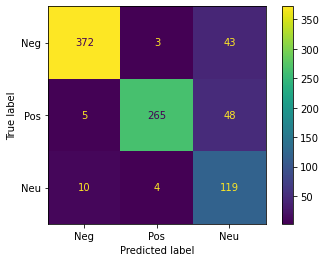

In [213]:
con = confusion_matrix(y_eval, pred_eval)
disp = ConfusionMatrixDisplay( confusion_matrix=con, display_labels={'Neg', 'Pos','Neu'}) 
disp.plot()
plt.show()

### Conclusión: Muy probablemente este modelo vaya a ser el que se seleccione, debido a su precisión y curiosamente concuerdo más con la clasificación que el modelo asigna, que el mismo que algunas etiquetas del dataset original contiene. *Nota: A futuro ver la posibilidad de realizar transfer learning 

# CASO 3 - TextBlob

### Al ser un sistema por bolsa de palabras, no se considera como modelo final y presenta una precisión baja, pues no toma en contexto el resto del sentido del tweet

In [54]:
from textblob import TextBlob

In [116]:
def get_subjectivity(text):
    txt_ = TextBlob(text).sentiment.subjectivity
    #print(txt_)
    return txt_

def get_polarity(text):
    return TextBlob(text).sentiment.polarity

def analysis(score):
    if score < 0:
        return 'N'
    elif score == 0:
        return 'Neu'
    else:
        return 'P'
    #elif score > 0:
        #return 'Positive'

In [117]:
local_test_df3 = test_df.copy()
#test_df3['Subjectivity'] = test_df['content'].apply(get_subjectivity)
local_test_df3['subjectivity'] = local_test_df3.content.apply(lambda x : get_subjectivity(x))

local_test_df3['polarity'] = local_test_df3['content'].apply(get_polarity)
local_test_df3['predictions'] = local_test_df3['polarity'].apply(analysis)

local_test_df3['sentiments'] = local_test_df3['sentiments'].replace(['P'], 1)
local_test_df3['sentiments'] = local_test_df3['sentiments'].replace(['N'], 0)
local_test_df3['sentiments'] = local_test_df3['sentiments'].replace(['NEU'], 2)
local_test_df3['predictions'] = local_test_df3['predictions'].replace(['P'], 1)
local_test_df3['predictions'] = local_test_df3['predictions'].replace(['N'], 0)
local_test_df3['predictions'] = local_test_df3['predictions'].replace(['Neu'], 2)

dist = local_test_df3['predictions'].value_counts().reset_index()
print(dist)
#local_test_df3.head(3)

   index  predictions
0      2          815
1      1           33
2      0           21


In [118]:
local_test_df3.head(3)

,tweetid,content,sentiments,subjectivity,polarity,predictions
1,768213567418036224,a que puto mal escribo b me sigo surrando help ha quedado raro el cometelo ahi jajajaja,0,0.0,0.0,2
2,768212591105703936,jajajaja la tuya y la d mucha gente seguro pero yo no puedo sin mi melena me muero,0,0.0,0.0,2
3,768221670255493120,quiero mogollon a pero sobretodo por lo rapido que contesta a los wasaps,1,0.0,0.0,2


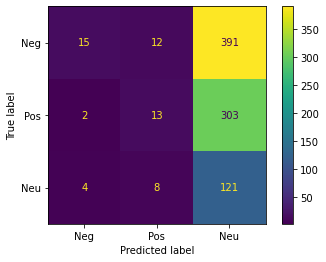

In [119]:
y_eval = local_test_df3[["sentiments"]].to_numpy()
pred_eval = local_test_df3[["predictions"]].to_numpy()


con = confusion_matrix(y_eval, pred_eval)
disp = ConfusionMatrixDisplay( confusion_matrix=con, display_labels={'Neg', 'Pos','Neu'}) 
disp.plot()
plt.show()

In [92]:
dist = local_test_df3['predictions'].value_counts().reset_index()
print(dist)

   index  predictions
0      0          815
1      1           33
2     -1           21


In [93]:
dist = test_df['sentiments'].value_counts().reset_index()
print(dist)

  index  sentiments
0     N         418
1     P         318
2   NEU         133
